In [1]:
import numpy as np
from scipy.stats import bernoulli
import seaborn as sns
np.random.seed(2023)

In [2]:
import utils

In [3]:
M, N, p_conn = 10, 750, 0.05 # very sparse, as 0.01 gives us on average every GC connects to 1 MC.
max_lim = 0.5 # for each entry Wnm the max connection strength

W = utils.create_network(M, N, p_conn, max_lim)

Max number of non zero GC connections 3
Average number of non zero GC connections 0.4693333333333333
Max strength of GC connections 0.8918735080294229
Average strength of GC connections 0.1149090052344403


In [4]:
W.shape

(10, 750)

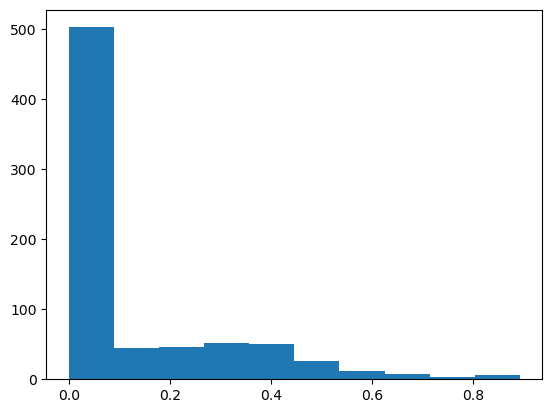

In [5]:
import matplotlib.pyplot as plt
plt.hist(W.T.sum(1))
plt.show()

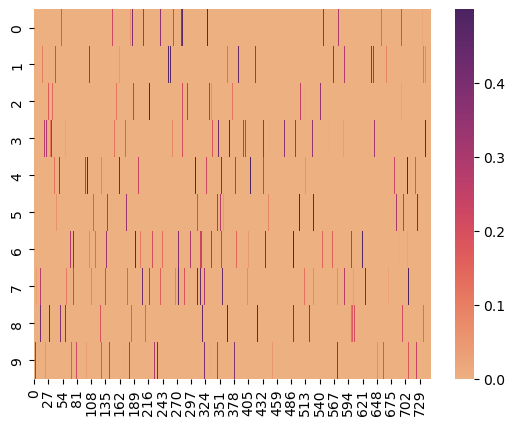

In [6]:
import seaborn as sns
sns.heatmap(W,cmap = 'flare')
plt.show()

In [7]:
from utils import *

In [8]:
list1 = np.linspace(0.01, 1, M)
odor1 = [x**2 for x in list1]
odor2 = [x**2 for x in list1[::-1]]
odors = np.array([odor1, odor2])

In [9]:
GC_responpse = get_GCact(W, odors.T, theta = .3)

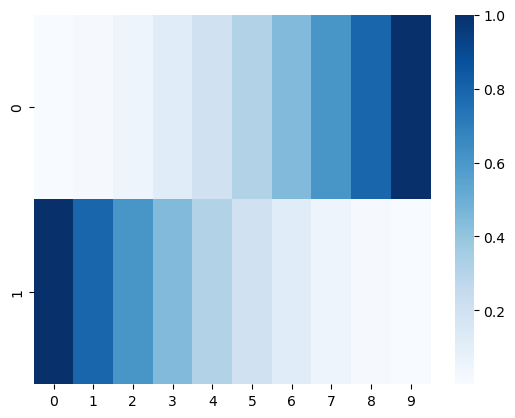

In [10]:
sns.heatmap(odors, cmap = 'Blues')
plt.show()

In [11]:
np.sum(GC_responpse !=0)

57

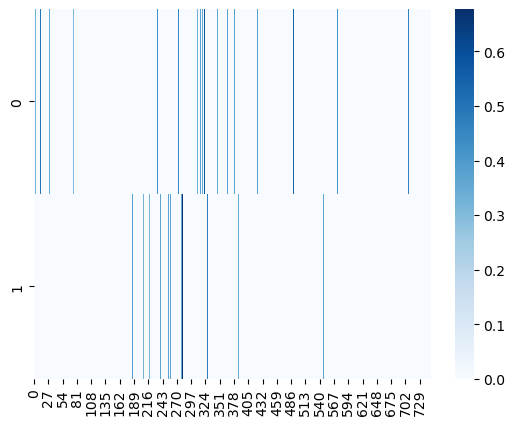

In [12]:
sns.heatmap(GC_responpse.T, cmap = 'Blues')
plt.show()

---
## inner loop

### Newton's method; it works!

Will do both that and line search; but perhaps line search is cheaper

Need to check negative why

In [13]:
import scipy as sc
## it'd be wise to leave W out, since in the inner loop it's not supposed to be changed.

def get_err(GC_act, odor_input, W):
    return odor_input - np.matmul(W, GC_act)

def get_loss(GC_act, odor_input, theta):
    '''
    Inputs:
    1) gc activities
    2) net mc activity, r_m
    3) gc threshold, theta

    Output: loss value
    '''
    MC_err = get_err(GC_act, odor_input, W)
    loss = (1/2)*(sc.linalg.norm(MC_err, 2)**2) + theta*np.sum(GC_act)
    
    return loss

def get_gradient(MC_err, theta, W):
    '''
    Inputs:
    1) gc activities
    2) net mc activity, r_m
    3) MC-GC network

    Function: gradient of the loss function w.r.t gc activations
    '''
  
    grad = - np.matmul(W.T, MC_err) + theta

    return grad

def generalized_grad(GC_iter, grad, theta, t):
    '''
    Proximal gradient computation 

    Inputs: 
    1) iterate: current iterate
    2) grad: gradient at current iterate
    3) theta: gc threshold
    4) t: steplength in [0,1]

    Output: proximal gradient
    '''
    GC_aftergrad =  utils.project(GC_iter - t*grad, theta)

    return GC_iter - GC_aftergrad

In [14]:
def newtons_update(GC_act, W, projected_grad):
    # ooops hessian is singular.. should have realized this :')
    # d = - np.linalg.inv(np.matmul(W, np.transpose(W))) @ grad
    pseudo_hess = np.linalg.pinv(np.matmul(W.T, W))
    d = - pseudo_hess @ projected_grad
    GC_act += d
    return GC_act


In [15]:
# initialize:
theta = .3
GC_responpse = get_GCact(W, odors.T, theta)
GC_act = GC_responpse[:,0]
MC_err = odor1 - np.matmul(W, GC_act)
loss = get_loss(GC_act,odor1, theta)
print(loss)

6.1028406469518615


In [16]:
## Newton update:
newtons_losses = []
for i in range(50):
    MC_err = odor1 - np.matmul(W, GC_act)
    grad = get_gradient(MC_err, theta, W)
    # norm_grad = grad/sc.linalg.norm(grad,2)
    projected_grad = generalized_grad(GC_act, grad, theta, t=1)
    GC_act = newtons_update(GC_act, W, projected_grad)
    loss = get_loss(GC_act, odor1, theta)
    newtons_losses.append(loss)
    if i%10 == 0:
        print(loss)

3.1797303920808857
-0.08936309495010297
-0.11455160950546006
-0.12010000466138193
-0.10590464971022329


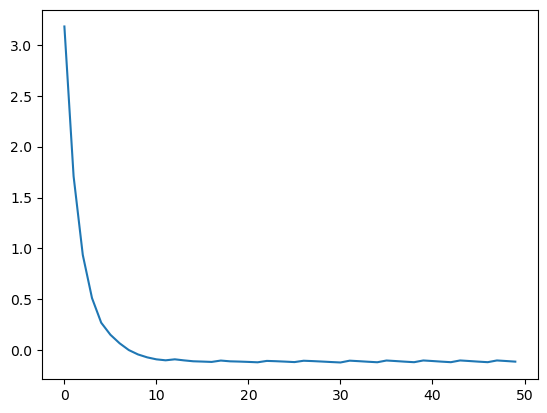

In [17]:
plt.plot(newtons_losses) # how can it go below???
plt.show()

### Simple line search: 

...it does not seem to be working very well with gradient projection; as most of the time projection reduced the gradent to a very tiny magnitude.

In [26]:
### this seems to be very slow

## Simple line search update

alpha = .5 # \in (0, 0.5)
beta = .8 # \in (0, 1)

def line_search_update(grad, GC_act, odor_input, theta, curr_loss): 
    t = 1
    gen_grad = generalized_grad(GC_act, grad, theta, t)
    new_loss =  get_loss(GC_act - gen_grad, odor_input, theta)
    # Armijo_bool = new_loss > curr_loss - alpha*t*(np.dot(grad, grad)) # I see grad*grad != generalized_grad* generalized_grad
   
    # a modification of the sufficient descent: 
    Armijo_bool = new_loss > curr_loss - alpha*t*(np.dot(gen_grad, gen_grad)) 

    count = 0
    
    while Armijo_bool and count< 50:
        t *= beta
        curr_loss = new_loss
        gen_grad = generalized_grad(GC_act, grad, theta, t)
        new_loss =  get_loss(GC_act - gen_grad, odor_input, theta)
        # Armijo_bool =  new_loss > curr_loss - alpha*t*(np.dot(grad, grad)) 
        Armijo_bool = new_loss > curr_loss - curr_loss - alpha*t*(np.dot(gen_grad, gen_grad)) 
        count += 1

    GC_act -= gen_grad
    
    return GC_act

In [27]:
# initialize:
theta = .3
GC_responpse = get_GCact(W, odors.T, theta)
GC_act = GC_responpse[:,0]
MC_err = odor1 - np.matmul(W, GC_act)
loss = get_loss(GC_act,odor1, theta)
print(loss)

6.1028406469518615


In [28]:
simp_line_search_loss = []
for i in range(2000):
    MC_err = odor1 - np.matmul(W, GC_act)
    grad = get_gradient(MC_err, theta, W)
    GC_act = line_search_update(grad, GC_act, odor1, theta, loss)
    loss = get_loss(GC_act, odor1, theta)
    simp_line_search_loss.append(loss)
    if i%10 == 0:
        print(loss)

1.1774022650000002
0.9676341784929985
0.9666272367480411
0.9666224031639883
0.9666223799615193
0.9666223798501414
0.9666223798496066
0.9666223798496042
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798496041
0.9666223798

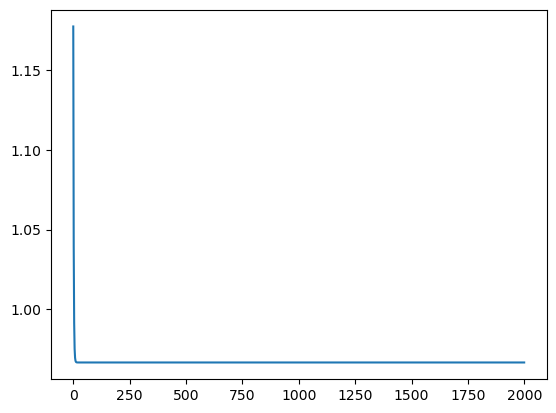

In [29]:
plt.plot(simp_line_search_loss)
plt.show()

In [22]:
# optimal step size 
def line_search_PGD(GC_act, odor_input, theta, grad, loss_curr, beta):
    '''
    Backtracking line search for projected gradient descent

    Inputs: 
    1) gc activities
    2) net mc activities, r_m
    3) theta: gc threshold
    4) W: MC-GC network
    5) grad: gradient at current iterate (current gc activities)
    6) loss_curr: loss function value at current iterate
    7) gamma: line search parameter 

    Output: steplength 
    '''
    t = 1
    iter = 50
    for i in range(iter):
        gen_grad = generalized_grad(GC_act, grad, theta, t)
        # print('Norm of generalized gradient', sc.linalg.norm(gen_grad, 2))
        new_iterate = GC_act - t*gen_grad
        new_loss = get_loss(new_iterate, odor_input, theta)

        ### I don't understand this...
        quad_approx = loss_curr - (t*np.matmul(grad, np.transpose(gen_grad))) + (t/2)*(sc.linalg.norm(gen_grad, 2)**2)
        
        if new_loss < loss_curr and new_loss <= quad_approx:
            break 
        else:
            t = beta*t # backtrack till objective value at new point is smaller than a quadratic approximation
            
        ### I don't understand the quadratic approximation part why sometimes use grad, and sometimes use gen_grad?

    return t if i < iter - 1 else 0

In [23]:
# initialize:
theta = .3
GC_responpse = get_GCact(W, odors.T, theta)
GC_act = GC_responpse[:,0]
MC_err = odor1 - np.matmul(W, GC_act)
loss = get_loss(GC_act,odor1, theta)
print(loss)
simp_line_search_loss = []

6.1028406469518615


In [32]:
t = 1
iters = 2    
t = t if i < iters else 0
t

0

In [24]:
jalaj_losses = []
for i in range(2000):
    MC_err = odor1 - np.matmul(W, GC_act)
    grad = get_gradient(MC_err, theta, W)
    norm_grad = grad/sc.linalg.norm(grad,2)  
    steplength = line_search_PGD(GC_act, odor1, theta, norm_grad, loss, beta =.9)
    if steplength > 0:
        GC_act -= steplength*generalized_grad(GC_act, norm_grad, theta, steplength)            
    loss = get_loss(GC_act, odor1, theta)
    jalaj_losses.append(loss)
    if i%10 == 0:
        print(loss)

2.240005822002347
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.9395604754492934
0.93956047544

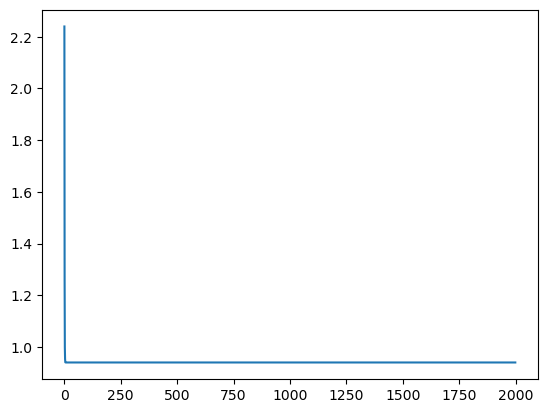

In [25]:
plt.plot(jalaj_losses)
plt.show()

1. track # of GC.

--
Outer loop:


In [26]:
etas = {'associate': 0.005, 'disassociate':0.005, 'forget':0.0005}

In [27]:
# regularized updates: Plasticity
def hebbian(GC_act, odor_input, etas, cap = True, cap_strength = 1):
    for a in range(len(GC_act)):
        for i in range(len(odor_input)):
            if GC_act[a] > 0 and odor_input[i] > 0:
                W[i,a] = min(W[i,a] + etas['associate']*odor_input[i]*GC_act[a], 1) 
            # can perhaps try not updating:
            elif GC_act[a] > 0 and odor_input[i] < 0:
                W[i,a] = max(W[i,a] + etas['disassociate']*odor_input[i]*GC_act[a], 0)
            else:
                W[i,a] = max(W[i,a] - etas['forget'], 0)
        if cap:
            if np.sum(W[:,a]) > cap_strength:
                W[:,a] = (cap_strength*W[:,a])/np.sum(W[:,a])

In [28]:
def sniff_cycle(odor_input, GC_act, W):    
    
    for _ in range(1000):
        MC_err = odor_input - np.matmul(W, GC_act)
        grad = get_gradient(MC_err, theta, W)
        norm_grad = grad/sc.linalg.norm(grad,2)  
        steplength = line_search_PGD(GC_act, odor_input, theta, norm_grad, loss, beta =.9)
        if steplength > 0:
            GC_act -= steplength*generalized_grad(GC_act, norm_grad, theta, steplength)

    return GC_act
           

In [30]:
# def dictionary_learning():

GC_responpse = get_GCact(W, odors.T, theta)
GC_act_1 = GC_responpse[:,0]
# MC_err_1 = odor1 - np.matmul(W, GC_act)

GC_act_2= GC_responpse[:,1]


for k in range(1000):
    if k%2:
        GC_act_1 = sniff_cycle(odor1, GC_act_1, W)
        hebbian(GC_act_1, odor1, etas, cap = True, cap_strength = 1)

    else: 
        GC_act_2 = sniff_cycle(odor2, GC_act_2, W)
        hebbian(GC_act_2, odor2, etas, cap = True, cap_strength = 1)  
    

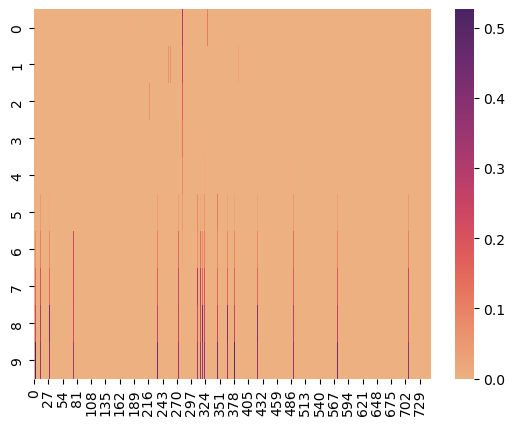

In [31]:
sns.heatmap(W, cmap = 'flare')
plt.show()

In [33]:
M, N, p_conn = 10, 750, 0.05 # very sparse, as 0.01 gives us on average every GC connects to 1 MC.
max_lim = 0.5 # for each entry Wnm the max connection strength

W = utils.create_network(M, N, p_conn, max_lim)

GC_responpse = get_GCact(W, odors.T, theta)
GC_act_1 = GC_responpse[:,0]
GC_act_2= GC_responpse[:,1]


for k in range(1000):
    if k%2:
        GC_act_1 = sniff_cycle(odor1, GC_act_1, W)
        hebbian(GC_act_1, odor1, etas, cap = True, cap_strength = 1)

    else: 
        GC_act_2 = sniff_cycle(odor2, GC_act_2, W)
        hebbian(GC_act_2, odor2, etas, cap = True, cap_strength = 1)  
    

Max number of non zero GC connections 4
Average number of non zero GC connections 0.476
Max strength of GC connections 1.0000000000000002
Average strength of GC connections 0.11622892634132298


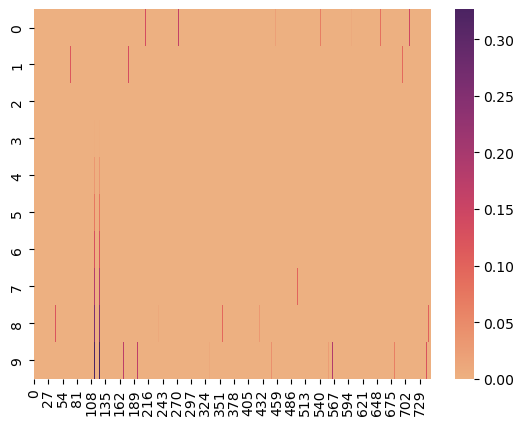

In [34]:
sns.heatmap(W, cmap = 'flare')
plt.show()

#### try the other way round to present.

In [35]:
M, N, p_conn = 10, 750, 0.05 # very sparse, as 0.01 gives us on average every GC connects to 1 MC.
max_lim = 0.5 # for each entry Wnm the max connection strength

W = utils.create_network(M, N, p_conn, max_lim)

GC_responpse = get_GCact(W, odors.T, theta)
GC_act_1 = GC_responpse[:,0]
GC_act_2= GC_responpse[:,1]


for k in range(1000):
    if k%2 == 0:
        GC_act_1 = sniff_cycle(odor1, GC_act_1, W)
        hebbian(GC_act_1, odor1, etas, cap = True, cap_strength = 1)

    else: 
        GC_act_2 = sniff_cycle(odor2, GC_act_2, W)
        hebbian(GC_act_2, odor2, etas, cap = True, cap_strength = 1)  

Max number of non zero GC connections 4
Average number of non zero GC connections 0.47333333333333333
Max strength of GC connections 1.0
Average strength of GC connections 0.1211369987757227


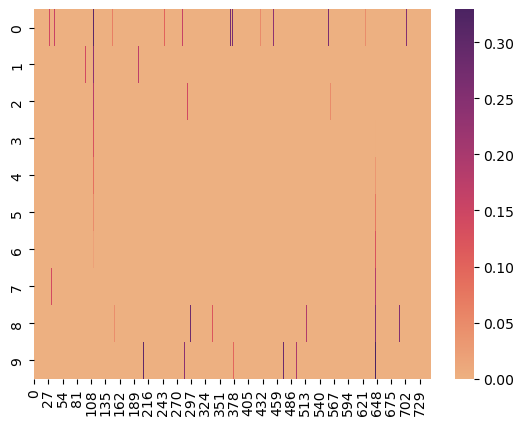

In [36]:
sns.heatmap(W, cmap = 'flare')
plt.show()

What do we need to plot the stats?
Where does the stochasticity coming from???!